# Librerie e funzioni

In [51]:
%matplotlib widget
import tarfile 
import urllib 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

# PROBLEMA DI REGRESSIONE BASE ********************************************************************************************************************************

In [2]:
# fetch_housing_data()
Housing = pd.read_csv('datasets/housing/housing.csv')
Housing.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


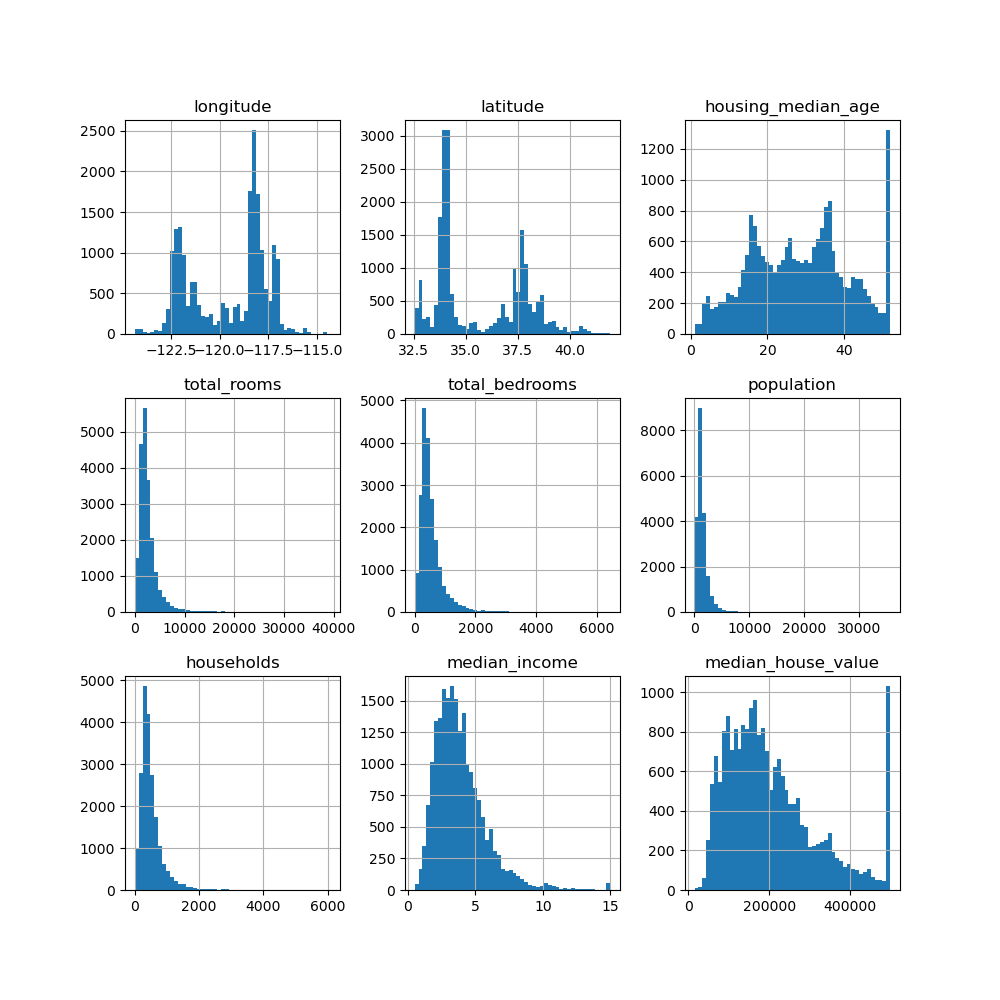

In [3]:
Housing.hist(bins=50, figsize=(10,10));

In [4]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(Housing, test_size=0.2, random_state=42)


#oppure per uno split stratificato
from sklearn.model_selection import StratifiedShuffleSplit

Housing["income_cat"] = pd.cut(Housing["median_income"],bins=[0., 1.5, 3.0, 4.5, 6., np.inf],labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(Housing, Housing["income_cat"]):
    strat_train_set = Housing.loc[train_index]
    strat_test_set = Housing.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [5]:
housing = strat_train_set.copy()

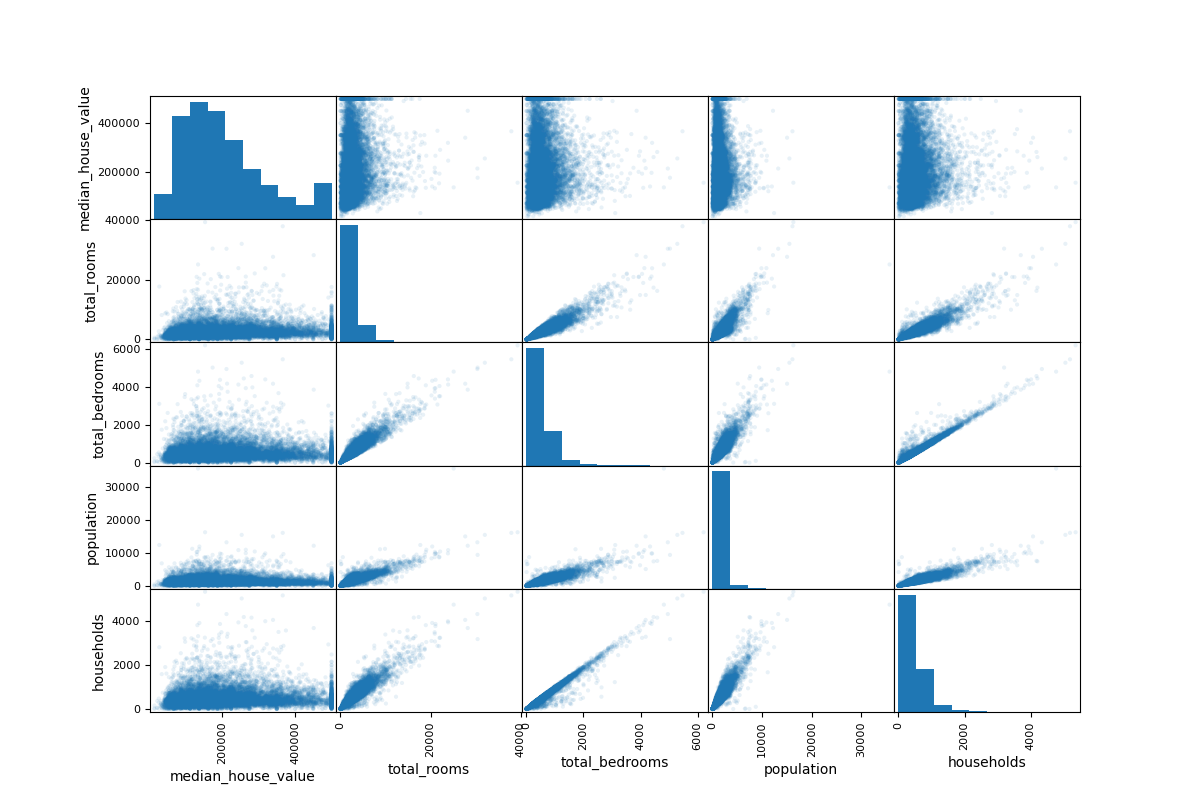

In [9]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value","total_rooms", "total_bedrooms", "population","households"]
scatter_matrix(housing[attributes], figsize=(12, 8),alpha=0.1);

In [11]:
#separo i labels dalle features
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
    ])

housing_num = housing.drop("ocean_proximity", axis=1)
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

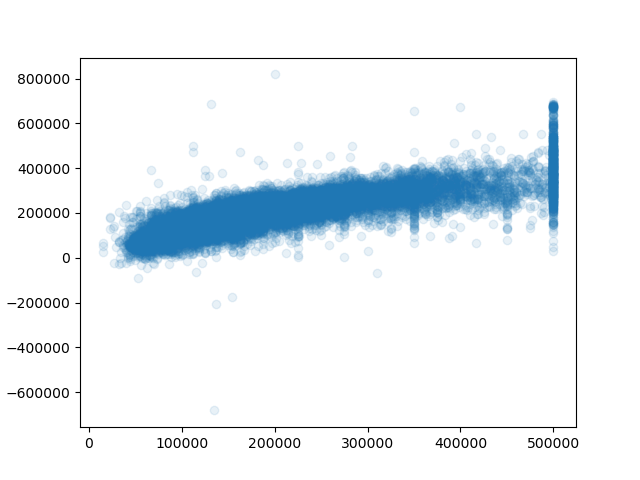

In [12]:
# CROSS-VALIDATION utile per validare diversi modelli suddividendo il train set in un train set piu' piccolo ed in un validation test

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

#regressione lineare,   fitto il modello sul train set e vedo le predizioni sempre sul train set (scovare overfitting)
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels);
housing_predictions = lin_reg.predict(housing_prepared)

plt.figure()
plt.scatter(housing_labels,housing_predictions,alpha=0.1)
#correlazione calcolata sul train set tra predizione e valore vero
corr_train = np.corrcoef(housing_labels,housing_predictions) 

# RMSE calcolato sul train set
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)    #il valore grande fa pensare ad un underfitting

#K-Fold cross-validation
scores = cross_val_score(lin_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)   #il fatto che siano circa uguali al precedente esclude un overfitting

# PROBLEMA DI CLASSIFICAZIONE *********************************************************************************************************************************************

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, data_home='/home/gianfranco/analisi/ml_example/datasets/' )

In [52]:
X_train = mnist['data'][:60000]
X_test = mnist['data'][60000:]

y_train = mnist['target'][:60000].astype(int)
y_test = mnist['target'][60000:].astype(int)

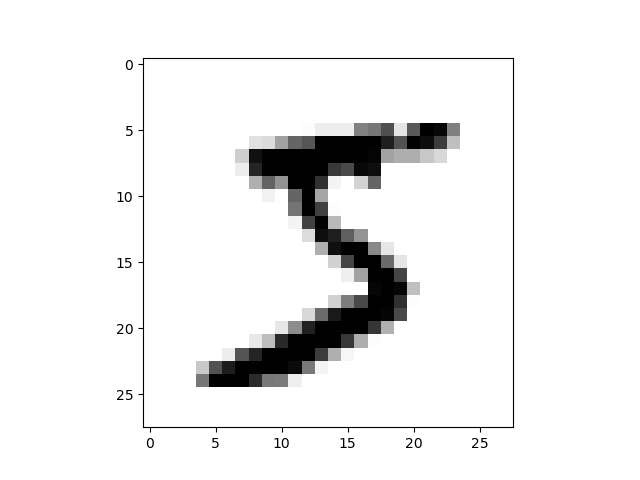

In [53]:
plt.imshow( np.array(x_train.iloc[0]).reshape(28,28), cmap="binary")
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

# svm_clf = SVC()
svm_clf = LinearSVC()
svm_clf.fit(X_train, y_train)

In [50]:
y_pred_train = svm_clf.predict(X_train) 

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import precision_score, recall_score,  f1_score
